In [1]:
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

In [2]:
train = pd.read_csv(r'C:\Users\44788\Desktop\coding\pynbs\Kaggle\train.csv')
test = pd.read_csv(r'C:\Users\44788\Desktop\coding\pynbs\Kaggle\test.csv')

In [3]:
Xarray = []
pixel_names = list(train.columns[1:])
for pixel in pixel_names:
    Xarray.append(list(train[pixel]))
Xtrain = np.array(Xarray)

In [4]:
Xtrain.shape

(784, 42000)

In [5]:
ytrain = np.array(train['label'])
def hot_ones_numpy(y):
    Y = []
    odd = []
    for element in y:
        if element == 0:
            Y.append([1,0,0,0,0,0,0,0,0,0])
        elif element == 1:
            Y.append([0,1,0,0,0,0,0,0,0,0])
        elif element == 2:
            Y.append([0,0,1,0,0,0,0,0,0,0])
        elif element == 3:
            Y.append([0,0,0,1,0,0,0,0,0,0])
        elif element == 4:
            Y.append([0,0,0,0,1,0,0,0,0,0])
        elif element == 5:
            Y.append([0,0,0,0,0,1,0,0,0,0])
        elif element == 6:
            Y.append([0,0,0,0,0,0,1,0,0,0])
        elif element == 7:
            Y.append([0,0,0,0,0,0,0,1,0,0])
        elif element == 8:
            Y.append([0,0,0,0,0,0,0,0,1,0])
        elif element == 9:
            Y.append([0,0,0,0,0,0,0,0,0,1])
    return np.array(Y).T
Ytrain = hot_ones_numpy(ytrain)

In [6]:
Xtrainbatches = np.array_split(Xtrain,330,axis=1)
Ytrainbatches = np.array_split(Ytrain,330,axis=1)

In [7]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z))) 

In [8]:
def softmax(z):
    z_x = np.exp(z - np.max(z))
    return z_x / np.sum(z_x)

In [9]:
def Relu(z):
    return np.maximum(0, z)

In [10]:
def initialize_weights_biases(rows, columns):
    return np.random.randn(rows, columns) * np.sqrt(2/columns+rows), np.zeros(shape=(rows, 1))

In [11]:
def initialize_weights_biases2(rows, columns):
    return np.random.randn(rows, columns) * 0.1, np.zeros(shape=(rows, 1))

In [12]:
def compute_cost(A5, ytrue, m):
    msum = -1/m
    first_term = ytrue * np.log(A5)
    second_term = (1-ytrue) * np.log(1-A5) 
    summing_term = first_term + second_term
    cost = msum * np.sum(summing_term)
    cost = np.squeeze(cost)      
    return cost

In [13]:
W1,b1 = initialize_weights_biases(400, 784)
W2,b2 = initialize_weights_biases(250, 400)
W3,b3 = initialize_weights_biases(50, 250)
W4,b4 = initialize_weights_biases(20, 50)
W5,b5 = initialize_weights_biases2(10, 20)

In [14]:
def forprop(W, A, b, m):
    epsilon = 1e-8
    z = np.dot(W, A) + b
    upsilon = 1./m * z
    sigma2 = 1./m * (z-upsilon)**2
    znorm = (z-upsilon)/(sigma2+epsilon)
    return znorm 

In [15]:
def forward_propogation(X,W1,b1,W2,b2,W3,b3,W4,b4,W5,b5,m):
    z1 = forprop(W1, X, b1, m)
    A1 = Relu(z1)
    z2 = forprop(W2, A1, b2, m)
    A2 = Relu(z2)
    z3 = forprop(W3, A2, b3, m)
    A3 = Relu(z3)
    z4 = forprop(W4, A3, b4, m)
    A4 = Relu(z4)
    z5 = forprop(W5, A4, b5, m)
    A5 = sigmoid(z5)
    A5 = softmax(A5)
    return A5, A4, A3, A2, A1

In [16]:
def backprop(W3, dZ3, A2, A1, W2, lambd, m):
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd / m * W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    return dZ2, dW2, db2

In [17]:
def backward_propogation(X, Y, A5, A4, A3, A2, A1, lambd, m):
    dZ5 = A5 - Y
    dW5 = 1./m * np.dot(dZ5, A4.T) + lambd / m * W5
    db5 = 1./m * np.sum(dZ5, axis=1, keepdims = True)
    dZ4, dW4, db4 = backprop(W5, dZ5, A4, A3, W4, lambd, m)
    dZ3, dW3, db3 = backprop(W4, dZ4, A3, A2, W3, lambd, m)
    dZ2, dW2, db2 = backprop(W3, dZ3, A2, A1, W2, lambd, m)
    dZ1, dW1, db1 = backprop(W2, dZ2, A1, X, W1, lambd, m)
    return dW5, db5, dW4, db4, dW3, db3, dW2, db2, dW1, db1

In [18]:
def upparam(W, dW, b, db, Adam_cache, learning_rate, layer_no, m):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    Adam_cache["VdW" + str(layer_no)] = beta1 * Adam_cache["VdW" + str(layer_no)] + (1 - beta1) * W
    Adam_cache["Vdb" + str(layer_no)] = beta1 * Adam_cache["Vdb" + str(layer_no)] + (1 - beta1) * b
    VdWcor = Adam_cache["VdW" + str(layer_no)] / (1 - beta1**m)
    Vdbcor = Adam_cache["Vdb" + str(layer_no)] / (1 - beta1**m)
    Adam_cache["SdW" + str(layer_no)] = beta2 * Adam_cache["SdW" + str(layer_no)] + (1 - beta2) * W**2
    Adam_cache["Sdb" + str(layer_no)] = beta2 * Adam_cache["Sdb" + str(layer_no)] + (1 - beta2) * b**2
    SdWcor = Adam_cache["SdW" + str(layer_no)] / (1 - beta2**m)
    Sdbcor = Adam_cache["Sdb" + str(layer_no)] / (1 - beta2**m)
    W = W - learning_rate * VdWcor / (np.sqrt(SdWcor) + epsilon)
    b = b - learning_rate * Vdbcor /(np.sqrt(Sdbcor) + epsilon)
    return W, b, Adam_cache

In [19]:
def initialize_Adam_values(weights, bias):
    return np.zeros_like(weights), np.zeros_like(bias)

In [20]:
Adam_cache ={'VdW1' : initialize_Adam_values(W1,b1)[0],
             'Vdb1' : initialize_Adam_values(W1,b1)[1],
             'SdW1' : initialize_Adam_values(W1,b1)[0],
             'Sdb1' : initialize_Adam_values(W1,b1)[1],
             'VdW2' : initialize_Adam_values(W2,b2)[0],
             'Vdb2' : initialize_Adam_values(W2,b2)[1],
             'SdW2' : initialize_Adam_values(W2,b2)[0],
             'Sdb2' : initialize_Adam_values(W2,b2)[1],
             'VdW3' : initialize_Adam_values(W3,b3)[0],
             'Vdb3' : initialize_Adam_values(W3,b3)[1],
             'SdW3' : initialize_Adam_values(W3,b3)[0],
             'Sdb3' : initialize_Adam_values(W3,b3)[1],
             'VdW4' : initialize_Adam_values(W4,b4)[0],
             'Vdb4' : initialize_Adam_values(W4,b4)[1],
             'SdW4' : initialize_Adam_values(W4,b4)[0],
             'Sdb4' : initialize_Adam_values(W4,b4)[1],
             'VdW5' : initialize_Adam_values(W5,b5)[0],
             'Vdb5' : initialize_Adam_values(W5,b5)[1],
             'SdW5' : initialize_Adam_values(W5,b5)[0],
             'Sdb5' : initialize_Adam_values(W5,b5)[1]}

In [21]:
def update_parameters(dW5, W5, db5, b5, dW4, W4, db4, b4, dW3, W3, db3, b3, dW2, W2, db2, b2, dW1, W1, db1, b1, Adam_cache, learning_rate, m):
    W5, b5, Adam_cache = upparam(W5, dW5, b5, db5, Adam_cache, learning_rate, 5, m)
    W4, b4, Adam_cache = upparam(W4, dW4, b4, db4, Adam_cache, learning_rate, 4, m)
    W3, b3, Adam_cache = upparam(W3, dW3, b3, db3, Adam_cache, learning_rate, 3, m)
    W2, b2, Adam_cache = upparam(W2, dW2, b2, db2, Adam_cache, learning_rate, 2, m)
    W1, b1, Adam_cache = upparam(W1, dW1, b1, db1, Adam_cache, learning_rate, 1, m)
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

In [22]:
def test_accuracy(A5, Y, m):
    correct_counter = 0
    prediction = []
    for ele1, ele2 in zip(A5.T, Y.T):
        pred = list(ele1).index((max(ele1)))
        data = list(ele2).index((max(ele2)))
        prediction.append([pred, data])
        if pred == data:
            correct_counter +=1
    return correct_counter/m * 100, prediction

In [23]:
def Neural_network(X, Y, Adam_cache, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, learning_rate, number_iters, lambd):
    costs = []
    accuracy = []
    iteration = 0
    for i in range(number_iters):
        for j, (x, y) in enumerate(zip(X, Y)):
            m = x.shape[1]
            A5, A4, A3, A2, A1 = forward_propogation(x,W1,b1,W2,b2,W3,b3,W4,b4,W5,b5,m)
            costs.append(compute_cost(A5, y, m))
            accuracy.append(test_accuracy(A5, y, m)[0])
            dW5, db5, dW4, db4, dW3, db3, dW2, db2, dW1, db1 = backward_propogation(x, y, A5, A4, A3, A2, A1, lambd, m)
            W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = update_parameters(dW5, W5, db5, b5, dW4, W4, db4, b4, dW3, W3, db3, \
                                                                       b3, dW2, W2, db2, b2, dW1, W1, db1, b1, Adam_cache, learning_rate, m)
            iteration +=1
            if iteration %100 == 0:
                print('current pass number', iteration, 'cost:', compute_cost(A5, y, m), 'accuracy:', test_accuracy(A5, y, m)[0])
    predictions = test_accuracy(A5, y, m)
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, costs, accuracy, A5, predictions

In [24]:
W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, costs, accuracy_score, A5, predictions = Neural_network(Xtrainbatches, Ytrainbatches, Adam_cache, \
                                                                                               W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, 0.0003, 5, 0.01)

C:\Users\44788\.conda\envs\learning\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


current pass number 100 cost: 7.248567499295898 accuracy: 8.661417322834646
current pass number 200 cost: 7.226413932788304 accuracy: 8.661417322834646
current pass number 300 cost: 7.2757395746266535 accuracy: 8.661417322834646
current pass number 400 cost: 7.278067085282846 accuracy: 11.71875
current pass number 500 cost: 7.23785710298283 accuracy: 8.661417322834646
current pass number 600 cost: 7.19529477645667 accuracy: 10.236220472440944
current pass number 700 cost: 7.188987384147266 accuracy: 6.25
current pass number 800 cost: 7.216078967057928 accuracy: 11.811023622047244
current pass number 900 cost: 7.239736208394727 accuracy: 7.874015748031496
current pass number 1000 cost: 7.224952768978114 accuracy: 9.375
current pass number 1100 cost: 7.218398756892604 accuracy: 8.661417322834646
current pass number 1200 cost: 7.266841698177325 accuracy: 11.023622047244094
current pass number 1300 cost: 7.277226933762611 accuracy: 18.11023622047244
current pass number 1400 cost: 7.2613939

Text(0.5, 0, 'number of iterations')

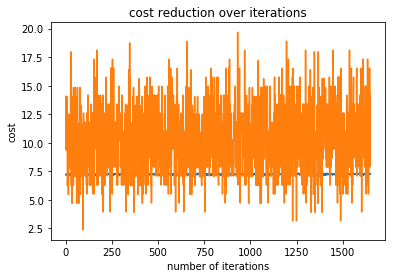

In [25]:
plt.plot(range(0,len(costs)), costs)
plt.plot(range(0,len(accuracy_score)), accuracy_score)
plt.title('cost reduction over iterations')
plt.ylabel('cost')
plt.xlabel('number of iterations')